In [1]:
import numpy as np
import scipy as sp
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

In [2]:
# Style cell
plt.rcParams['text.usetex']       = True
plt.rcParams['font.size']         = 30
plt.rcParams['font.family']       = 'serif'
plt.rcParams['font.serif']        = 'Computer Modern Roman'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.major.size']  = 8
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.major.size']  = 8
colors = ['#2b83ba', '#ba622b', '#80a339', '#80a339']

In [3]:
# Need to load pickled models if we want to use pickled pystan results
with open('../../stan_models/models_bin/prevalence_model.bin', 'rb') as f:
    _ = pickle.load(f)
with open('../../stan_models/models_bin/incidence_model.bin', 'rb') as f:
    __ = pickle.load(f)

# Helper functions

In [4]:
def bounding_curves(fit, lo_quart=0.05, hi_quart=0.95, prop='beta_func'):
    
    if prop == 'beta_func' or prop == 'z_tilde':
        func_bundle = fit[prop]
    elif prop == 'y_tilde':
        func_bundle = fit['y_tilde'][:,:,1]
    elif prop == 'beta_over_gamma':
        func_bundle = fit['beta_func'] / np.einsum('i,j->ij', fit['gamma_rate'], np.ones(fit['beta_func'].shape[1]))
    else:
        raise(Exception('Not implemented'))

    num_points = len(func_bundle[0, :])
    bounds = np.zeros((num_points, 2))

    for idx in range(num_points):
        bounds[idx, 0] = sp.nanquantile(func_bundle[:, idx], lo_quart)
        bounds[idx, 1] = sp.nanquantile(func_bundle[:, idx], hi_quart)

    return bounds

In [5]:
def get_beta_range(fit, num_steps_beta=None):
    if fit.model_name[0:10] == "prevalence":
        max_Y = max(fit.data['Y'])
    else:
        max_Y = fit.data['max_Y']
    delta = fit.data['overshoot']
    if num_steps_beta is None:
        num_steps_beta = fit.data['num_steps_beta']
    return np.linspace(-max_Y * delta, max_Y * (1 + delta), num_steps_beta), max_Y

def get_Y_range(fit, num_steps_y):
    return np.linspace(0, 1, num_steps_y)

def get_Z_range(fit, num_steps_y):
    return np.linspace(0, 1, num_steps_y)

In [6]:
datatype = 'prevalence'
with open('clustered_networks/' + datatype + '_independent.pck', 'rb') as f:
    fit_indep_prev =  pickle.load(f)
with open('clustered_networks/' + datatype + '_interacting.pck', 'rb') as f:
    fit_inter_prev =  pickle.load(f)
    
datatype = 'incidence'
with open('clustered_networks/' + datatype + '_independent.pck', 'rb') as f:
    fit_indep_inc =  pickle.load(f)
with open('clustered_networks/' + datatype + '_interacting.pck', 'rb') as f:
    fit_inter_inc =  pickle.load(f)

# Generate figure

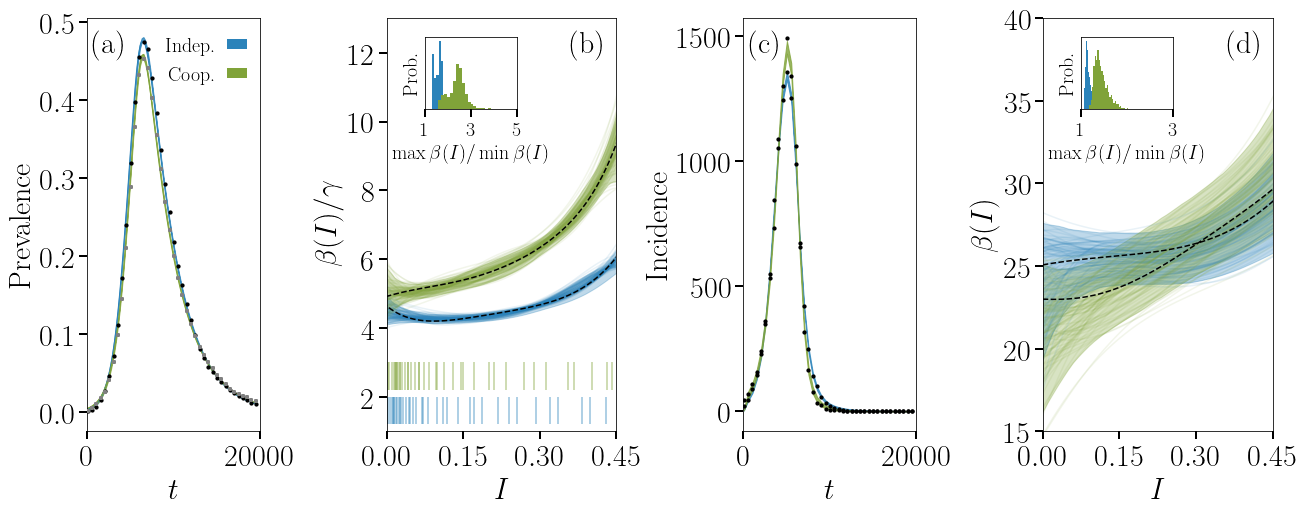

In [7]:
np.random.seed(42)
num_shown = 100
lo = 0.025
hi = 0.975

fig = plt.figure(figsize=(18, 7),facecolor='white')
fig.subplots_adjust(bottom=0.15)
gs = gridspec.GridSpec(1, 4, width_ratios=[1.5,2,1.5,2])

time_series_indep = pd.read_csv('../time_series/clustered_networks/independent.txt', sep="\t")
time_series_inter = pd.read_csv('../time_series/clustered_networks/interacting.txt', sep="\t")

t_max_indep = time_series_indep['t'].iloc[-1]
t_max_inter = time_series_inter['t'].iloc[-1]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Time series and fit (prevalence)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.subplot(gs[:,0])
plt.xlabel(r'$t$')
plt.ylabel(r'Prevalence')

y_r = get_Y_range(fit_indep_prev, fit_indep_prev.data['num_steps_y'])
bounds = bounding_curves(fit_indep_prev, lo, hi, 'y_tilde')
plt.fill_between(y_r * t_max_indep, bounds[:,0], bounds[:,1], alpha=0.8, color=colors[0])
plt.plot(y_r * t_max_indep, fit_indep_prev['y_tilde'][0,:,1],  color=colors[0], lw=1, label='Indep.')
plt.scatter(time_series_indep['t'], time_series_indep['Y(t)'],
            c='k',
            lw=2, marker='o', zorder=10, s=5,
            label='')

y_r = get_Y_range(fit_inter_prev, fit_inter_prev.data['num_steps_y'])
bounds = bounding_curves(fit_inter_prev, lo, hi, 'y_tilde')
plt.fill_between(y_r * t_max_inter, bounds[:,0], bounds[:,1], alpha=0.8, color=colors[2])
plt.plot(y_r * t_max_inter, fit_inter_prev['y_tilde'][0,:,1],  color=colors[2], lw=1, label='Coop.')
plt.scatter(time_series_inter['t'], time_series_inter['Y(t)'],
            c='gray',
            lw=2, marker='s', zorder=10, s=5,
            label='')
    
leg = plt.legend(loc=1, markerfirst=False, shadow=False, fancybox=False, prop={'size':20}, frameon=False, handlelength=0.5, numpoints=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(10.0)
plt.xlim(0, 20000);



plt.text(0.03, 0.97, r"(a)",
         horizontalalignment='left',
         verticalalignment='top',transform=plt.gca().transAxes)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Complex contagion functions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.subplot(gs[1])


beta_r, max_Y = get_beta_range(fit_indep_prev)
bounds = bounding_curves(fit_indep_prev, lo, hi, 'beta_over_gamma')
plt.fill_between(beta_r, bounds[:,0], bounds[:,1], alpha=0.3, color=colors[0])


beta_r, max_Y = get_beta_range(fit_inter_prev)
bounds = bounding_curves(fit_inter_prev, lo, hi, 'beta_over_gamma')
plt.fill_between(beta_r, bounds[:,0], bounds[:,1], alpha=0.3, color=colors[2])

for sample_idx in np.random.choice(fit_indep_prev['beta_func'].shape[0], num_shown):
    plt.plot(beta_r, fit_indep_prev['beta_func'][sample_idx,:]/fit_indep_prev['gamma_rate'][sample_idx], c=colors[0], alpha=0.1)
for sample_idx in np.random.choice(fit_inter_prev['beta_func'].shape[0], num_shown):
    plt.plot(beta_r, fit_inter_prev['beta_func'][sample_idx,:]/fit_inter_prev['gamma_rate'][sample_idx], c=colors[2], alpha=0.1)

plt.vlines(fit_indep_prev.data['Y'], 1.2, 2, alpha=0.5, color=colors[0])
plt.vlines(fit_inter_prev.data['Y'], 2.2, 3, alpha=0.5, color=colors[2])


MAP = np.argmax(fit_indep_prev.extract('lp__')['lp__'])
plt.plot(beta_r, fit_indep_prev['beta_func'][MAP]/fit_indep_prev['gamma_rate'][MAP], ls='--', c='k', zorder=20)
MAP = np.argmax(fit_inter_prev.extract('lp__')['lp__'])
plt.plot(beta_r, fit_inter_prev['beta_func'][MAP]/fit_inter_prev['gamma_rate'][MAP], ls='--', c='k', zorder=20)

plt.xlim(0, 0.45)
plt.ylim(1, 13)
plt.xticks([0, 0.15, 0.30, 0.45])
plt.xlabel(r'$I$')
plt.ylabel(r'$\beta(I)/\gamma$')



plt.text(0.8, 0.97, r"(b)",
         horizontalalignment='left',
         verticalalignment='top',transform=plt.gca().transAxes)


inset_axes(plt.gca(), width="40%", height=1, loc=2,  bbox_to_anchor=(0.1,-0.01,1,1), bbox_transform=plt.gca().transAxes)
plt.xlabel(r'$\max \beta(I) / \min \beta(I)$', fontsize=20)
plt.ylabel(r'Prob.', fontsize=20)
plt.xticks([1, 3, 5] , fontsize=20)
plt.xlim(1,5)
plt.hist(np.max(fit_indep_prev['beta_func'], axis=1)/ np.min(fit_indep_prev['beta_func'], axis=1), color=colors[0])
plt.hist(np.max(fit_inter_prev['beta_func'], axis=1)/ np.min(fit_inter_prev['beta_func'], axis=1), color=colors[2],bins=40)

plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.tick_params(\
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off




plt.subplot(gs[2])
plt.xlabel(r'$t$')
plt.ylabel(r'Incidence')

y_r = get_Y_range(fit_indep_inc, fit_indep_inc.data['num_steps_y'])
bounds = bounding_curves(fit_indep_inc, lo, hi, 'z_tilde')
plt.fill_between(fit_indep_inc.data['ts'] * t_max_indep, bounds[:,0], bounds[:,1], alpha=0.8, color=colors[0])
plt.scatter(time_series_indep['t'], time_series_indep['Z(t)'],
            c='k',
            lw=2, marker='o', zorder=10, s=5,
            label='')

y_r = get_Y_range(fit_inter_inc, fit_inter_inc.data['num_steps_y'])
bounds = bounding_curves(fit_inter_inc, lo, hi, 'z_tilde')
plt.fill_between(fit_inter_inc.data['ts'] * t_max_inter, bounds[:,0], bounds[:,1], alpha=0.8, color=colors[2])
plt.scatter(time_series_inter['t'], time_series_inter['Z(t)'],
            c='k',
            lw=2, marker='o', zorder=10, s=5,
            label='')
plt.xlim(0, 20000);

plt.text(0.03, 0.97, r"(c)",
         horizontalalignment='left',
         verticalalignment='top',transform=plt.gca().transAxes)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Complex contagion functions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



plt.subplot(gs[3])

beta_r, max_Y = get_beta_range(fit_indep_inc)
bounds = bounding_curves(fit_indep_inc, lo, hi, 'beta_func')
plt.fill_between(beta_r, bounds[:,0], bounds[:,1], alpha=0.3, color=colors[0])
for sample_idx in np.random.choice(fit_indep_inc['beta_func'].shape[0], num_shown):
    plt.plot(beta_r, fit_indep_inc['beta_func'][sample_idx,:], c=colors[0], alpha=0.1)


beta_r, max_Y = get_beta_range(fit_inter_inc)
bounds = bounding_curves(fit_inter_inc, lo, hi, 'beta_func')
plt.fill_between(beta_r, bounds[:,0], bounds[:,1], alpha=0.3, color=colors[2])
for sample_idx in np.random.choice(fit_inter_inc['beta_func'].shape[0], num_shown):
    plt.plot(beta_r, fit_inter_inc['beta_func'][sample_idx,:], c=colors[2], alpha=0.1)

plt.vlines(fit_indep_inc.data['Z'], 1.2, 2, alpha=0.5, color=colors[0])
plt.vlines(fit_inter_inc.data['Z'], 2.2, 3, alpha=0.5, color=colors[2])


MAP = np.argmax(fit_indep_inc.extract('lp__')['lp__'])
plt.plot(beta_r, fit_indep_inc['beta_func'][MAP], ls='--', c='k', zorder=20)
MAP = np.argmax(fit_inter_inc.extract('lp__')['lp__'])
plt.plot(beta_r, fit_inter_inc['beta_func'][MAP], ls='--', c='k', zorder=20)

plt.text(0.8, 0.97, "(d)",
         horizontalalignment='left',
         verticalalignment='top',transform=plt.gca().transAxes)


plt.xlim(0, 0.45)
plt.ylim(15, 40)
plt.xticks([0, 0.15, 0.30, 0.45])
plt.xlabel(r'$I$')
plt.ylabel(r'$\beta(I)$')




inset_axes(plt.gca(), width="40%", height=1, loc=2,  bbox_to_anchor=(0.1,-0.01,1,1), bbox_transform=plt.gca().transAxes)
plt.xlabel(r'$\max \beta(I) / \min \beta(I)$', fontsize=20)
plt.ylabel(r'Prob.', fontsize=20)
plt.xticks([1,3] , fontsize=20)
plt.xlim(1,3)
plt.hist(np.max(fit_indep_inc['beta_func'][:,:45], axis=1)/ np.min(fit_indep_inc['beta_func'][:,:45], axis=1), color=colors[0], bins=50)
plt.hist(np.max(fit_inter_inc['beta_func'][:,:45], axis=1)/ np.min(fit_inter_inc['beta_func'][:,:45], axis=1), color=colors[2],bins=40)

plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.tick_params(\
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off




plt.tight_layout(pad=0.1)
plt.savefig('Fig3.pdf', bbox_inches='tight')